# Introduction to Federated Learning with CIFAR10

```
TODO: rdar://118980539 (when external docs are hosted, change all pointers to it)
```

This tutorial demonstrates how to train a DNN with `pfl` using Private Federated Learning.
We will learn how to train a simple neural network in simulation to classify images from the CIFAR10 dataset.
This dataset contains images of 10 different types of objects.
Each image is labelled with one object. The dataset is not inherently split into real users, so we have to create artificial user partitions.

This tutorial is in TensorFlow. If you are looking for a more advanced tutorial in PyTorch, check out [this tutorial](https://github.com/apple/pfl-research/tree/main/tutorials/Introduction%20to%20PFL%20research%20with%20FLAIR.ipynb).


## 0. Install environment & `pfl`

To use this notebook, follow these prerequisite steps:

```
TODO: change instructions when put on colab rdar://105243072 (Make a colab notebook available for training CIFAR10)
```

1. Follow installation instructions at https://github.com/apple/pfl-research/blob/main/benchmarks/README.md#setup-environment
2. Add the kernel created by Poetry to the notebook:

```
pip install jupyter
python -m ipykernel install --name "notebook-tutorial"
```

4. Start the notebook:

```
python -m jupyter notebook
```


In [1]:
import sys
import os

# Additional packages needed to run notebook
!{sys.executable} -m pip install matplotlib nest_asyncio


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


<div class="alert alert-block alert-warning">
If you installed the packages above, you need to restart the kernel of the notebook by clicking on "Kernel -> Restart"
</div>


## 1. Preparing data for simulations


Use the script `pfl-research/dataset/cifar10/download_preprocess.py` to download the CIFAR10 dataset from its original source and preprocess into pickles:


In [2]:
# sys.path.append(os.path.abspath('..'))
# print(sys.path)
!(cd ../benchmarks; {sys.executable} -m dataset.cifar10.download_preprocess --output_dir ./data/cifar10)

Found ./data/cifar10/raw_data/cifar-10-python.tar.gz on disk, skip download
Merging files ['./data/cifar10/raw_data/cifar-10-batches-py/data_batch_1', './data/cifar10/raw_data/cifar-10-batches-py/data_batch_2', './data/cifar10/raw_data/cifar-10-batches-py/data_batch_3', './data/cifar10/raw_data/cifar-10-batches-py/data_batch_4', './data/cifar10/raw_data/cifar-10-batches-py/data_batch_5'].
Saved processed data to ./data/cifar10/cifar10_train.p
Merging files ['./data/cifar10/raw_data/cifar-10-batches-py/test_batch'].
Saved processed data to ./data/cifar10/cifar10_test.p


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

# Both Jupyter and `pfl` uses async, nest_asyncio allows `pfl` to run inside the notebook
import nest_asyncio

nest_asyncio.apply()

# append the root directory to your paths to be able to reach the examples.
sys.path.append("../benchmarks")
tf.random.set_seed(7)
np.random.seed(7)

# Always import the `pfl` model first to let `pfl` know which Deep Learning framework you will use.
from pfl.model.tensorflow import TFModel

2024-06-23 18:57:23.145406: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 18:57:23.335930: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 18:57:23.335977: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 18:57:23.338907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 18:57:23.531731: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 18:57:23.533381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-06-23 18:57:29.899254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 18:57:29.900068: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-06-23 18:57:30.099505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-23 18:57:30.099529: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make

In [4]:
from dataset.cifar10 import load_and_preprocess

# Train only on classes 0 and 2 in this example
exclude_classes = [1, 3, 4, 5, 6, 7, 8, 9]
train_images, train_labels, channel_means, channel_stddevs = load_and_preprocess(
    "../benchmarks/data/cifar10/cifar10_train.p", exclude_classes=exclude_classes
)
val_images, val_labels, _, _ = load_and_preprocess(
    "../benchmarks/data/cifar10/cifar10_test.p", channel_means, channel_stddevs, exclude_classes=exclude_classes
)
# Convert labels to one-hot vectors.
one_hots = np.eye(10)
train_labels = one_hots[train_labels].squeeze()
val_labels = one_hots[val_labels].squeeze()

print("Train data shapes:", "features:", train_images.shape, "targets:", train_labels.shape)
print("Dev data shapes:  ", "features:", val_images.shape, "targets:", val_labels.shape)

Train data shapes: features: (10000, 32, 32, 3) targets: (10000, 10)
Dev data shapes:   features: (2000, 32, 32, 3) targets: (2000, 10)


As displayed above, the images are of dimensions `32x32` with `3` color channels and the labels are one-hot vectors `[0-9]`. Also, you can see that we exclude all but 2 classes, Airplane (0) and Bird (2), to make things simple for this tutorial.

As the data is not inherently split into real users, we need to use [ArtificialFederatedDataset](https://apple.github.io/pfl-research/reference/data.html#pfl.data.federated_dataset.ArtificialFederatedDataset) to sample datapoints to create artificial user datasets for federated learning, which in turn requires a function for sampling the length of a user dataset and the actual datapoints of this dataset.

Firstly, we define a function which samples the length of a dataset from a Poisson distribution with mean 5:


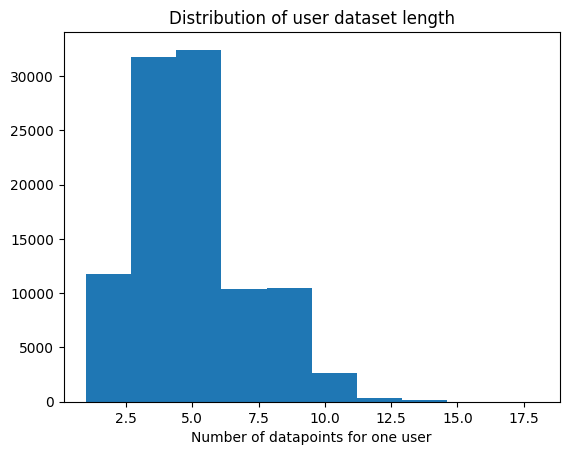

In [5]:
def user_dataset_len_sampler():
    while True:
        length = np.random.poisson(5)
        if length > 0:
            return length


# Visualize sampling from this function.
plt.xlabel("Number of datapoints for one user")
plt.title("Distribution of user dataset length")
plt.hist([user_dataset_len_sampler() for _ in range(100000)])
plt.show()

Secondly, we define a function `Callable[[length: int], List[int]]` which samples a set of datapoint identifiers of a given length. We use the helper function `get_data_sampler` to build a sampler which draws a set of datapoints uniformly. This will result in IID user datasets. When doing this for your use case you might want to consider sampling in a way which creates more realistic and heterogeneous user datasets.


In [6]:
from pfl.data.sampling import get_data_sampler

train_data_sampler = get_data_sampler("random", len(train_images))
val_data_sampler = get_data_sampler("random", len(val_images))

print("Sampled a user dataset of length 5 with datapoint ids ", train_data_sampler(5))

Sampled a user dataset of length 5 with datapoint ids  [7192 2501 4752 3850 5314]


Thirdly, the federated datasets are initialized using the above sampling functions. We also create a central dataset for central evaluation.


In [7]:
from pfl.data.federated_dataset import ArtificialFederatedDataset
from pfl.data.dataset import Dataset

train_federated_dataset = ArtificialFederatedDataset.from_slices(
    [train_images, train_labels], train_data_sampler, user_dataset_len_sampler
)
val_federated_dataset = ArtificialFederatedDataset.from_slices(
    [val_images, val_labels], val_data_sampler, user_dataset_len_sampler
)
central_data = Dataset(raw_data=[val_images, val_labels])

When iterating through an artificial federated dataset, a user dataset is sampled every iteration.


User: <pfl.data.dataset.Dataset object at 0x7f8c1fa530d0>, unique user seed: 385465319


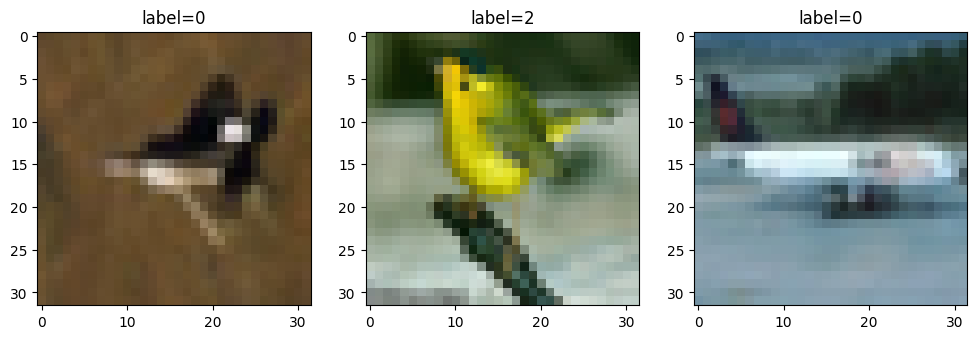

In [8]:
user, seed = next(train_federated_dataset)
print("User: {}, unique user seed: {}".format(user, seed))
fig, axes = plt.subplots(1, len(user), figsize=(12, 6))
for ax, image, label in zip(axes, *user.raw_data):
    ax.set_title("label={}".format(np.argmax(label)))
    ax.imshow((image.reshape(3, 32, 32).transpose(1, 2, 0) * channel_stddevs + channel_means).astype(np.uint8))

## 2. Defining the model


Defining a model in `pfl` is exactly the same as you would normally define a model for training. One of `pfl`’s strengths is that it is agnostic to any Deep Learning framework, which enables `pfl` to support multiple Deep Learning frameworks.

At this moment, frameworks supported by `pfl` are TensorFlow and PyTorch.
`pfl` also support ML models like GBDTs which use numpy.

We will define a Keras model in the exact same way as we would for regular centralized training.


In [9]:
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

inputs = Input(shape=(32, 32, 3))
inputs_flat = Reshape((3072,), input_shape=(32, 32, 3))(inputs)
layer1 = Dense(50, activation="relu")(inputs_flat)
layer2 = Dense(50, activation="relu")(layer1)
predictions = Dense(10, activation="softmax")(layer2)

# configure the model for training,
# specifying inputs, outputs, optimiser, loss, metrics, etc.
keras_model = Model(inputs=inputs, outputs=predictions)
keras_model.compile(SGD(0.01), loss="categorical_crossentropy")

keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 reshape (Reshape)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 50)                153650    
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 156710 (612.15 KB)
Trainable params: 156710 (612.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To train a model using `pfl`, a [Model](https://apple.github.io/pfl-research/reference/model.html#models) object must be instantiated for the Deep Learning framework in which the model was defined. A `pfl` Model acts as an adapter between the model of the Deep Learning framework and `pfl`. We use Keras with TensorFlow for this example.

The central optimizer is an input parameter to the model object. This optimizer is used when applying the aggregated model update to the central model.


In [10]:
from pfl.model.tensorflow import TFModel

metrics = {"accuracy": tf.keras.metrics.CategoricalAccuracy(), "loss": tf.keras.metrics.CategoricalCrossentropy()}
model = TFModel(model=keras_model, central_optimizer=tf.keras.optimizers.SGD(1.0), metrics=metrics)

## 3. Training a model using Private Federated Learning


`Backend` is a component in `pfl` used to collect and average statistics from user devices. [SimulatedBackend](https://apple.github.io/pfl-research/reference/aggregate.html#pfl.aggregate.SimulatedBackend) provides simulation. For larger datasets or models, it also [supports distributed simulations](https://apple.github.io/pfl-research/tutorials/simulation_distributed.html) with multiple processes, GPUs and machines.

`pfl` provides various privacy mechanisms in [pfl.privacy](https://apple.github.io/pfl-research/reference/privacy.html#module-privacy).
These mechanisms are used to guarantee local and/or central differential privacy and are parameterized by `SimulatedBackend` in simulations.

Below, we initialize `SimulatedBackend` with Gaussian Moments Accountant as the central differential privacy mechanism, which provides the minimum privacy guarantee required by most use-cases.


In [11]:
from pfl.aggregate.simulate import SimulatedBackend
from pfl.privacy import CentrallyAppliedPrivacyMechanism, GaussianMechanism, PLDPrivacyAccountant
from pfl.serverless.backend.simulate import SimulatedServerlessBackend

cohort_size = 200
central_num_iterations = 5
population = 1e7

# Use Gaussian Moments Accountant, and transform it to a central privacy mechanism.
# accountant = PLDPrivacyAccountant(
#     num_compositions=central_num_iterations,
#     sampling_probability=cohort_size / population,
#     mechanism="gaussian",
#     epsilon=2,
#     delta=1e-5,
# )
# central_privacy = CentrallyAppliedPrivacyMechanism(
#     GaussianMechanism.from_privacy_accountant(accountant=accountant, clipping_bound=1.0)
# )

# Instantiate simulated federated averaging
# simulated_backend = SimulatedBackend(
#     training_data=train_federated_dataset, val_data=val_federated_dataset, postprocessors=[central_privacy]
# )

simulated_backend = SimulatedServerlessBackend(
    training_data=train_federated_dataset, val_data=val_federated_dataset, postprocessors=[]
)

The main component of a `pfl` modeling setup is the algorithm. In this tutorial, we will be using the [Federated Averaging](https://arxiv.org/pdf/1602.05629.pdf) algorithm. `pfl` implements Federated Averaging using the class [FederatedAveraging](https://apple.github.io/pfl-research/reference/algorithm.html#pfl.algorithm.federated_averaging.FederatedAveraging).

Everything is tied together in the `run` method of an algorithm. This method requires the model, backend, optional callbacks, as well as hyperparameters, which depends on the model and algorithm combination. In this case, training a neural network with federated averaging requires a `NNTrainHyperParams` and `NNAlgorithmParams`.

Important hyperparameters for federated learning include `local_learning_rate` and `local_num_epochs` which respectively specify the learning rate and the number of training epochs to be used for local training on devices during federated averaging. These hyperparameters differ to `central_learning_rate` and `central_num_iterations` which apply to training the central model using aggregated updates from devices.


In [12]:
from pfl.algorithm import FederatedAveraging, NNAlgorithmParams
import pfl.algorithm.serverless.federated_averaging as serverless
from pfl.callback import CentralEvaluationCallback
from pfl.hyperparam import NNTrainHyperParams, NNEvalHyperParams
import importlib

os.environ["PFL_GRAPH_CACHE"] = "false"

importlib.reload(serverless)
# %load_ext autoreload
# %autoreload 2

%load_ext autoreload
%autoreload

model_train_params = NNTrainHyperParams(local_learning_rate=0.05, local_num_epochs=2, local_batch_size=5)

# Do full-batch evaluation to run faster.
model_eval_params = NNEvalHyperParams(local_batch_size=None)

algorithm_params = NNAlgorithmParams(
    central_num_iterations=central_num_iterations,
    evaluation_frequency=4,
    train_cohort_size=cohort_size,
    val_cohort_size=10,
)

callbacks = [CentralEvaluationCallback(central_data, model_eval_params, 4)]

algorithm = serverless.ServerlessFederatedAveraging()
algorithm.run(
    backend=simulated_backend,
    model=model,
    algorithm_params=algorithm_params,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=callbacks,
)

SimpleStoreConfig(name='simple', params=EmptyConfigParams())
1
pickling model
done pickling model
pickling iteration
done pickling iteration
pickling algorithm_params
done pickling algorithm_params
pickling model_train_params
done pickling model_train_params
pickling model_eval_params
done pickling model_eval_params
Time to save data:  0.025182008743286133
unpickling model

done unpickling model
unpickling iteration

done unpickling iteration
unpickling algorithm_params

done unpickling algorithm_params
unpickling model_train_params

done unpickling model_train_params
unpickling model_eval_params

done unpickling model_eval_params
pickling central_contexts
done pickling central_contexts
pickling model
done pickling model
pickling all_metrics
done pickling all_metrics
Time to run function:  0.12487053871154785
unpickling central_contexts

done unpickling central_contexts
unpickling model

done unpickling model
unpickling all_metrics

done unpickling all_metrics
Metrics at iteration 0 ()

## Next steps

This concludes the basics for simulating PFL using a simple dataset with TensorFlow.

- If you want to learn more about how to do research with `pfl`, check out [this tutorial](https://github.com/apple/pfl-research/tree/main/tutorials/Introduction%20to%20PFL%20research%20with%20FLAIR.ipynb) in PyTorch.
- If you want to try the benchmark suite and learn setups for different datasets and models, see [our benchmark setups](https://github.com/apple/pfl-research/tree/main/benchmarks).
